In [1]:
import garden_ai
from garden_ai import step, GardenClient
from typing import Annotated
import numpy as np
client = GardenClient()

# First, we needed to register our pretrained ML model with the garden service.
# When we registered the pretrained model (model.pth copied in this directory) via `$ garden-ai model register ...` 
# We were given this model name, which we can use to reference the model in a pipeline. 
REGISTERED_MODEL_NAME = "owenpriceskelly@uchicago.edu/bragg-model-seedling"

In [2]:
# Next, we define a plain python function that uses the named model to run inference 
# We decorate it with `@step` so that we can use it to build up a pipeline

@step
def run_inference(
    input_data: Annotated[np.ndarray, "image map with shape=([11,11])"],
    model=garden_ai.Model(REGISTERED_MODEL_NAME),  # loads the registered model by name, with a `.predict()` method
) -> Annotated[np.ndarray, "list of Bragg peak positions with shape=([1,2])"]:
    # scale back peak location by multiply with patch size [sic]
    return 11 * model.predict(input_data)

# we also define a (slightly contrived) preprocessing step
@step
def fix_axes_and_dtype(input_data: np.ndarray) -> Annotated[np.ndarray, "image map with shape=([11,11])"]:
    import numpy as np
    # Add two new singleton dimensions to the input data 
    preprocessed = input_data[np.newaxis, np.newaxis]

    # Convert the data type to float32
    preprocessed = preprocessed.astype('float32')
    return preprocessed

In [3]:
# make a simple Pipeline using the steps we just defined
# (metadata copied from analogous DLHub publish code where applicable)
braggNN_cpu = client.create_pipeline(
    title="BraggNN Demo Pipeline",
    pip_dependencies=["torch==1.8.0", "numpy==1.21.1"],
    python_version="3.9.16",
    steps=(fix_axes_and_dtype, run_inference),  # steps run in order, passing output to subsequent steps
    authors=[
        "Ravi, Nikil",
        "Chaturvedi, Pranshu",
        "Huerta, E.A.",
        "Liu, Zhengchun",
        "Scourtas, Aristana",
        "Schmidt, KJ",
        "Chard, Ryan",
        "Blaiszik, Ben",
    ],
    contributors=["Price Skelly, Owen"],
    version="0.0.1",
    year=2023,
    tags=[],
    short_name="braggNN_cpu",
    doi="10.23677/9zy0-z857",
)

In [4]:
# now we need to register the pipeline for remote execution
# build a container with the pipeline's specific dependencies/python version
# then register the pipeline so that it will execute from that container
container_id = '5ae7a9ce-cf82-4823-9ee6-09d8d6ecfc9b' # (reuse a known container uuid to skip slow build step)
# container_id = client.build_container(braggNN_cpu) # <-- to build a fresh container
client.register_pipeline(braggNN_cpu, container_id)
print(f"Registered pipeline '{braggNN_cpu.doi}'!")

Registered pipeline '10.23677/9zy0-z857'!


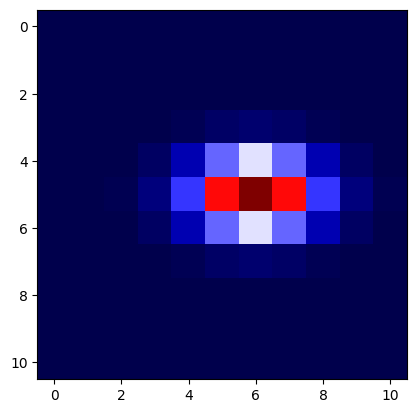

In [6]:
# now that we've registered our pipeline, we can test its remote execution against some sample input 
# (copied from dlhub publish notebook)
import numpy as np
from matplotlib import pyplot as plt
def make_demo_input():
    """generate and plot some simple input data for BraggNN model"""
    
    # use a simple gaussian for demo
    # node that models in this repo are pre-trained with real experiment data
    # the simple gaussian data may not simplify anything but makes a challenge to the model
    # as the train data and testing data are not IID.
    X_test = np.zeros((11, 11))
    x_cen, y_cen = 6.0, 5.0

    sig_x, sig_y = 0.6, 1.5
    for x in range(11):
        for y in range(11):
            X_test[y][x] = 1000*(np.exp(-(x-x_cen)*(x-x_cen)/2*sig_x -(y-y_cen)*(y-y_cen)/2*sig_y))

    # the input needs to be normalize to 0-1, e.g., rescale using min-max norm
    X_test = (X_test - X_test.min()) / (X_test.max() - X_test.min())

    plt.imshow(X_test, cmap='seismic')
    plt.show(); plt.close()
    return X_test

demo_input = make_demo_input()

In [8]:
# results we want to reproduce from DLHub-hosted copy of the same model:
expected_results = np.array([[5.9369993, 5.1481276]], dtype='float32')  

# to run remotely, use the client to fetch our newly registered pipeline -- 
# note that our pipeline is only available to us at this point; 
# it can't be discovered/used by others until it's part of a published Garden
bragg_remote = client.get_registered_pipeline("10.23677/9zy0-z857")

results = bragg_remote(
    demo_input,
    endpoint="86a47061-f3d9-44f0-90dc-56ddc642c000",  # execute on Globus Compute endpoint of choice
)
print(results)
results == expected_results # cool!

Output()

[[5.9369993 5.1481276]]


array([[ True,  True]])

In [10]:
# now that we've sanity-checked the pipeline's remote execution, we can publish it as part of a Garden:
bragg_garden = client.create_garden(
    title="BraggNN Demo Garden", 
    authors=["Owen Price Skelly"], 
    description="Recreates the BraggNN DLHub publication flow from \
https://github.com/blaiszik/dlhub_publish/blob/main/Bragg_model_code_notebook/inference-notebook.ipynb",
    doi='10.23677/z9m9-m734',
)
# include the pipeline by just its DOI:
bragg_garden.pipeline_ids += ['10.23677/9zy0-z857'] 


In [11]:
# Finally, publish our new garden, making it (and its pipeline) discoverable by other garden users
# (see example discovery/execution flow of this garden and pipeline in braggNN_garden_remote_inference.ipynb)
client.publish_garden_metadata(bragg_garden) 